In [1]:
import os
import os.path as op
import numpy as np
import re
import itertools
from typing import Tuple, Iterator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.stats import ttest_1samp
# from util.io.coherence import *

In [42]:
# Load data

df = pd.DataFrame()
root = Path('../data/bids/derivatives/abr/')
for file in root.rglob("*"):
    if '.pkl' not in file.name:
        continue
    print(file)
    sub_df = pd.read_pickle(file)
    df = df.append(sub_df)
df = df.reset_index()
df

../data/bids/derivatives/abr/sub-29_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-41_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-24_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-14_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-11_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-25_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-39_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-4_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-31_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-35_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-8_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-43_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-40_task-dichotic_run-1_abr.pkl


/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_

../data/bids/derivatives/abr/sub-9_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-30_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-5_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-42_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-6_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-38_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-33_task-dichotic_run-1_abr.pkl


/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_11174/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_

,index,sub,task,run,tone_num,stream,attended,right_channels,x,y,dB_diff
0,0,29,dichotic,1,1,l,True,AF4,273,366,-1.405150
1,1,29,dichotic,1,1,l,True,C2,264,245,-6.168212
2,2,29,dichotic,1,1,l,True,C4,305,245,4.302575
3,3,29,dichotic,1,1,l,True,C6,346,245,-2.336631
4,4,29,dichotic,1,1,l,True,T8,385,245,-5.849975
...,...,...,...,...,...,...,...,...,...,...,...
6463,319,33,dichotic,1,3,r,False,P8,354,150,-4.158728
6464,320,33,dichotic,1,3,r,False,PO4,274,121,-4.725843
6465,321,33,dichotic,1,3,r,False,PO8,318,114,-1.300532
6466,322,33,dichotic,1,3,r,False,TP10,416,181,1.756627


In [24]:
# Create Iterator over different conditions

tone_num_options = [1, 2, 3]
stream_options = ['l', 'r']
attended_options = [True, False]
subs = np.unique(df['sub']).tolist()

KeyType = Tuple[int, str, bool]

# def iterConditions(tone_num_options, stream_options, attended_options, subs) -> Iterator[KeyType]:
#     for tone_num in tone_num_options:
#         for stream in stream_options:
#             for attended in attended_options:
#                 for sub in subs:
#                     key = (tone_num, stream, attended, sub)
#                     yield key
                    
def iterConditions(tone_num_options, stream_options, attended_options) -> Iterator[KeyType]:
    for tone_num in tone_num_options:
        for stream in stream_options:
            for attended in attended_options:
                key = (tone_num, stream, attended)
                yield key

In [43]:
# Compute group means

df_means = df.groupby(['tone_num', 'stream', 'attended', 'right_channels', 'x', 'y'], sort=False)['dB_diff'].mean()
df_means = df_means.reset_index()
df_means

,tone_num,stream,attended,right_channels,x,y,dB_diff
0,1,l,True,AF4,273,366,-0.309566
1,1,l,True,C2,264,245,-0.136337
2,1,l,True,C4,305,245,0.049295
3,1,l,True,C6,346,245,-0.405126
4,1,l,True,T8,385,245,0.067567
...,...,...,...,...,...,...,...
319,3,r,False,P8,354,150,-1.203248
320,3,r,False,PO4,274,121,-0.014748
321,3,r,False,PO8,318,114,0.988570
322,3,r,False,TP10,416,181,-0.890918


In [48]:
def plot_map(df, condition):
    ax = sns.relplot(x = "x", y = "y", size = "dB_diff", sizes=(15, 200), data = df).set(title=str(condition))
    ax.despine(left = True, bottom = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabels('')
    ax.set_ylabels('')

(1, 'l', True)
(1, 'l', False)
(1, 'r', True)
(1, 'r', False)
(2, 'l', True)
(2, 'l', False)
(2, 'r', True)
(2, 'r', False)
(3, 'l', True)
(3, 'l', False)
(3, 'r', True)
(3, 'r', False)


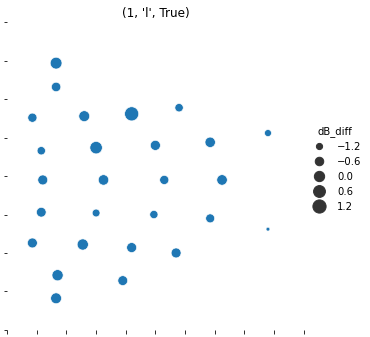

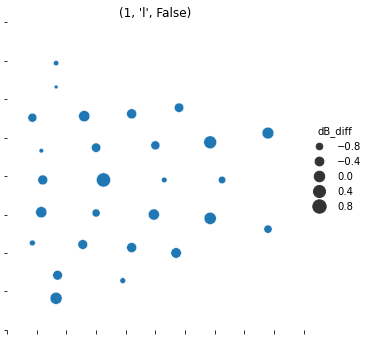

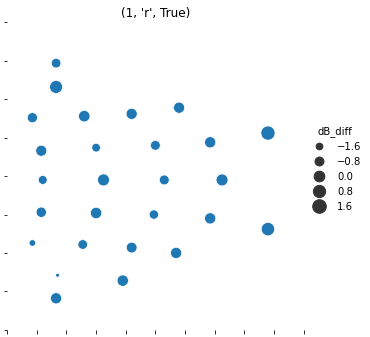

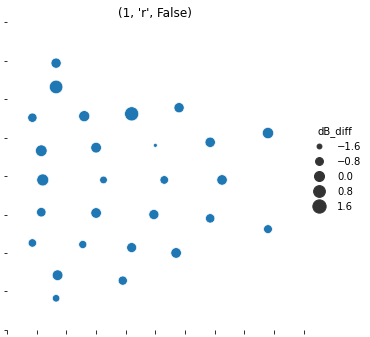

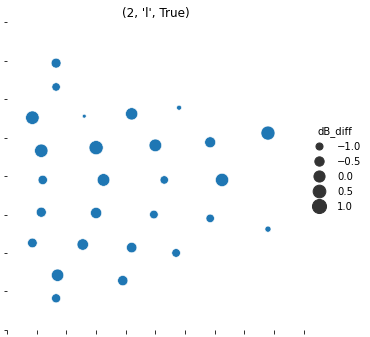

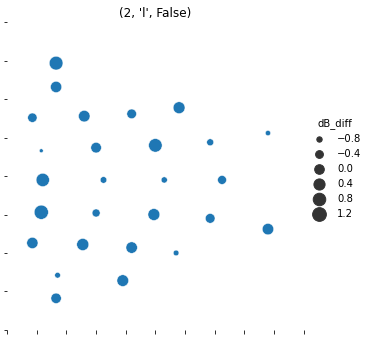

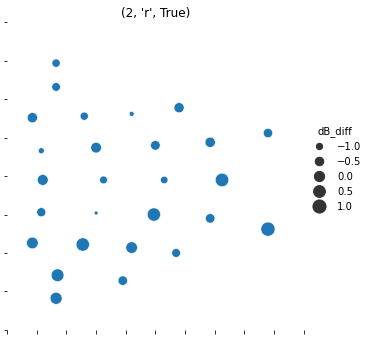

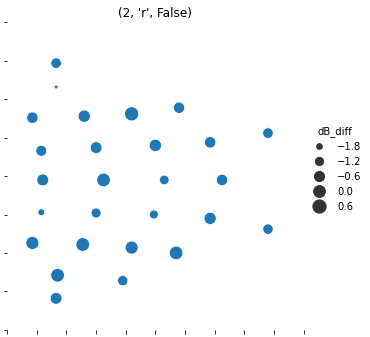

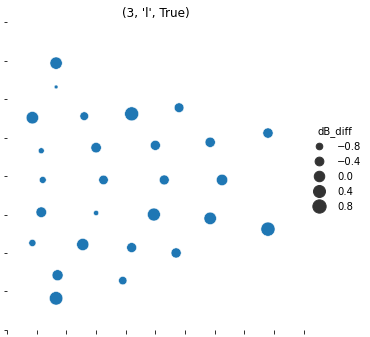

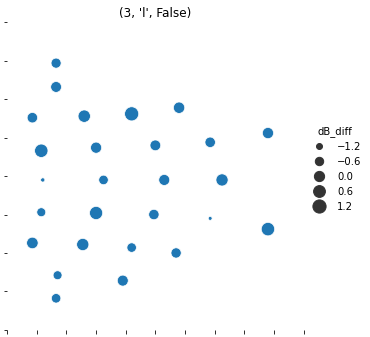

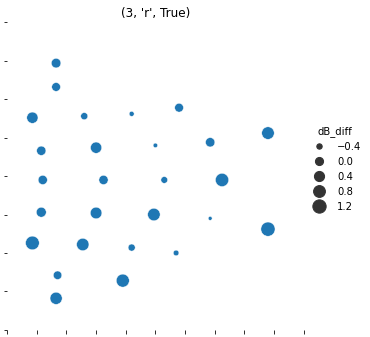

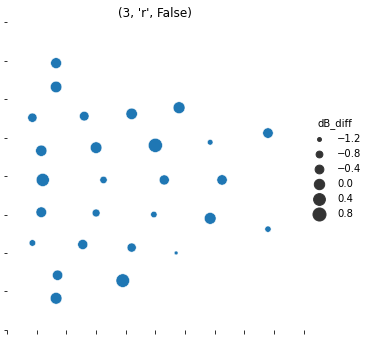

In [49]:
# Plot

for condition in iterConditions(tone_num_options, stream_options, attended_options):
    tone_num = condition[0]
    stream = condition[1]
    attended = condition[2]
    row = df_means[(df_means['tone_num'] == tone_num) & (df_means['stream'] == stream) & (df_means['attended'] == attended)]
    row = row.reset_index()
    print(condition)
    plot_map(row, condition)